In [1]:
import hopsworks
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
from matplotlib import pyplot
from hsml.schema import Schema
from hsml.model_schema import ModelSchema
import joblib
import os
from sklearn.ensemble import RandomForestClassifier



/home/codespace/.python/current/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# You have to set the environment variable 'HOPSWORKS_API_KEY' for login to succeed
project = hopsworks.login()
fs = project.get_feature_store()

Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/194714
Connected. Call `.close()` to terminate connection gracefully.


In [3]:
# The feature view is the input set of features for your model. The features can come from different feature groups.    
# You can select features from different feature groups and join them together to create a feature view
wine_fg = fs.get_feature_group(name="wine", version=1)
query = wine_fg.select_all()
feature_view = fs.get_or_create_feature_view(name="wine",
                                  version=1,
                                  description="Read from Wine Quality dataset",
                                  labels=["quality"],
                                  query=query)


In [24]:
# You can read training data, randomly split into train/test sets of features (X) and labels (y)        
X_train, X_test, y_train, y_test = feature_view.train_test_split(test_end=0.2)



ValueError: Invalid split input. You should specify either `test_size` or (`train_end` or `test_start`). `test_size` should be between 0 and 1 if specified.

In [25]:
# Initialize the Random Forest classifier
model = RandomForestClassifier(n_estimators=100, max_depth=10,random_state=1)  # You can adjust parameters here

# Train the classifier
model.fit(X_train, y_train)


RandomForestClassifier(max_depth=10, random_state=1)

In [26]:
X_train

,type,volatile_acidity,chlorides,density,alcohol
0,1,0.320000,0.04100,0.99235,11.0
1,1,0.200000,0.03000,0.99320,10.2
5,1,0.230000,0.04500,0.99220,11.3
6,1,0.180000,0.04000,0.99062,12.0
7,1,0.475000,0.04700,0.98988,13.4
...,...,...,...,...,...
5286,1,0.290000,0.05921,0.99280,11.5
5287,1,0.318549,0.04600,0.99520,10.1
5289,0,0.174292,0.06800,0.99414,12.8
5290,1,0.348656,0.05500,0.99405,9.1


In [27]:
y_train

,quality
0,1
1,1
5,1
6,1
7,1
...,...
5286,1
5287,1
5289,1
5290,1


In [29]:
X_test

,type,volatile_acidity,chlorides,density,alcohol
2,1,0.180000,0.042000,0.99400,9.4
3,1,0.280000,0.042000,0.99060,12.4
4,1,0.445000,0.040000,0.99380,10.8
10,1,0.280000,0.038000,0.99120,11.6
11,0,0.420000,0.088000,0.99610,9.2
...,...,...,...,...,...
5283,0,0.560000,0.078000,0.99294,10.5
5284,1,0.283765,0.044000,0.99740,8.7
5288,1,0.345504,0.041000,0.99254,9.4
5291,1,0.360000,0.082392,0.99560,10.1


In [28]:
# Predict labels for the test set
y_pred = model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Print classification report
report = classification_report(y_test, y_pred)
print("Classification Report:")
print(report)

Accuracy: 0.75
Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.61      0.65       410
           1       0.77      0.84      0.80       649

    accuracy                           0.75      1059
   macro avg       0.74      0.72      0.73      1059
weighted avg       0.75      0.75      0.74      1059



In [20]:
# Compare predictions (y_pred) with the labels in the test set (y_test)
metrics = classification_report(y_test, y_pred,output_dict=True)
results = confusion_matrix(y_test, y_pred)

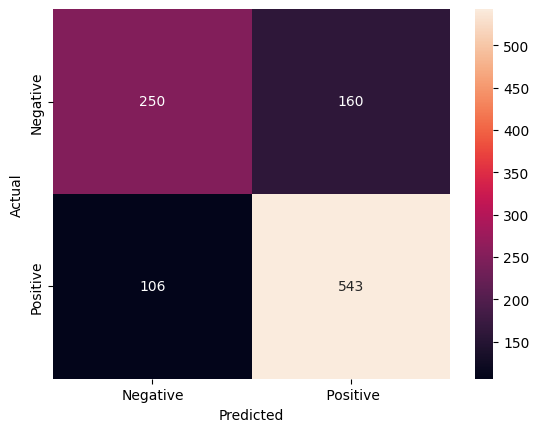

In [21]:
# Create the confusion matrix as a figure, we will later store it as a PNG image file
df_cm = pd.DataFrame(results,["Negative", "Positive"],["Negative"," Positive"])
cm = sns.heatmap(df_cm, annot=True, fmt='d')
cm.set_xlabel('Predicted')
cm.set_ylabel('Actual')

fig = cm.get_figure()

In [22]:
# We will now upload our model to the Hopsworks Model Registry. First get an object for the model registry.
mr = project.get_model_registry()

# The contents of the 'iris_model' directory will be saved to the model registry. Create the dir, first.
model_dir="wine_model"
if os.path.isdir(model_dir) == False:
    os.mkdir(model_dir)

# Save both our model and the confusion matrix to 'model_dir', whose contents will be uploaded to the model registry
joblib.dump(model, model_dir + "/wine_model.pkl")
fig.savefig(model_dir + "/confusion_matrix.png")    

# Specify the schema of the model's input/output using the features (X_train) and labels (y_train)
input_schema = Schema(X_train)
output_schema = Schema(y_train)
model_schema = ModelSchema(input_schema, output_schema)

# Create an entry in the model registry that includes the model's name, desc, metrics
iris_model = mr.python.create_model(
    name="wine_model", 
    metrics={"accuracy" : metrics['accuracy']},
    model_schema=model_schema,
    description="Wine Quality Predictor"
)

# Upload the model to the model registry, including all files in 'model_dir'
iris_model.save(model_dir)


Connected. Call `.close()` to terminate connection gracefully.


Uploading: 100.000%|██████████| 4063977/4063977 elapsed<00:03 remaining<00:003.34it/s]
Uploading: 100.000%|██████████| 20059/20059 elapsed<00:01 remaining<00:001,  3.34it/s]
Uploading: 100.000%|██████████| 537/537 elapsed<00:01 remaining<00:00<00:12,  3.02s/it]
Model export complete: 100%|██████████| 6/6 [00:12<00:00,  2.15s/it]                   

Model created, explore it at https://c.app.hopsworks.ai:443/p/194714/models/wine_model/3


Model(name: 'wine_model', version: 3)